# Experiments with Doc2Vec

Try to represent code in Doc2Vec. 

## Setup

In [2]:
import multiprocessing
from pathlib import Path

import gensim.models.doc2vec
import regex
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from javalang import tokenizer

from code_embeddings.utils import tokenize

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"


## Build and Train the Model

In [3]:
test_code_dir = Path('test_data')
train_code_dir = Path('training_data')
models_dir = Path('models')

In [4]:
def split_methods(code):
    """Parse Java files into separate methods

        :param code: Java code to parse.
        :rtype: map
    """
    pattern = r'(?:(?:public|private|static|protected)\s+)*\s*[\w\<\>\[\]]+\s+\w+\s*\([^{]+({(?:[^{}]+\/\*.*?\*\/|[^{}]+\/\/.*?$|[^{}]+|(?1))*+})'
    scanner = regex.finditer(pattern, code, regex.MULTILINE)
    return map(lambda match: match.group(0), scanner)

In [5]:
def read_train_corpus():
    count = 0
    for i, file in enumerate(train_code_dir.glob('./java_projects/**/*.java')):
        if not file.is_file():  # oddly, some of these are not files
            continue
        with file.open() as f:
            try:
                code = f.read()
                methods = split_methods(code)
                for method in methods:
                    tokens = list(tokenizer.tokenize(method))
                    tokens = [token for t in tokens for token in t.value.split(" ")]
                    if tokens:
                        tag = "Method_%s" % count
                        count += 1
                        yield TaggedDocument(tokens, [tag])
            except tokenizer.LexerError as e:
                # print("%s: %s" % (type(e).__name__, e))
                pass
            except UnicodeDecodeError as e:
                # print("%s: %s" % (type(e).__name__, e))
                pass
            except Exception as e:
                print("%s: %s" % (type(e).__name__, e))
                pass
        if i % 10000 == 0:
            print("Processed %s records" % i)
        if i > 100000:
            break


%time train_corpus = list(read_train_corpus())
print("Training corpus size: %s" % len(train_corpus))


Processed 10000 records


Processed 20000 records


Processed 30000 records


Processed 40000 records


Processed 50000 records


Processed 60000 records


Processed 70000 records


Processed 80000 records


Processed 90000 records


Processed 100000 records
CPU times: user 13min 55s, sys: 24.8 s, total: 14min 20s
Wall time: 14min 56s
Training corpus size: 606108


In [6]:
# doc2vec parameters
vector_size = 50
window_size = 15
min_count = 1
sampling_threshold = 1e-5
negative_size = 5
epochs = 400
dm = 0  # 0 = dbow; 1 = dmpv
worker_count = multiprocessing.cpu_count()  # number of parallel processes

In [7]:
%time 
model = Doc2Vec(train_corpus,
                vector_size=vector_size,
                window=window_size,
                min_count=min_count,
                sample=sampling_threshold,
                negative=negative_size,
                dbow_words=1,
                epochs=epochs, 
                dm=dm,
                workers=worker_count)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [8]:
model.save(str(models_dir / "github-java-vectors.bin"))

In [9]:
model.wv.most_similar('i')

[('++', 0.9650440216064453),
 (']', 0.9251419305801392),
 ('0', 0.9192928671836853),
 ('[', 0.9188427925109863),
 ('int', 0.8976515531539917),
 ('length', 0.8961997032165527),
 ('1', 0.8421670794487),
 ('size', 0.8378034234046936),
 ('for', 0.7989552617073059),
 ('j', 0.7830016016960144)]

In [10]:
model.wv.most_similar('count')

[('++', 0.77963787317276),
 ('%', 0.7347809672355652),
 ('size', 0.7335939407348633),
 ('total', 0.7297653555870056),
 ('size:"', 0.7182334065437317),
 ('<=', 0.7167933583259583),
 ('i', 0.7119099497795105),
 ('limit', 0.7075383067131042),
 ('>=', 0.6996421217918396),
 ('0:', 0.69398033618927)]

In [11]:
model.wv.most_similar('NullPointerException')

[('"Cannot', 0.7176927328109741),
 ('UnsupportedOperationException', 0.7117345929145813),
 ('throw', 0.7110745310783386),
 ('IllegalStateException', 0.7000792622566223),
 ('"Not', 0.6967915892601013),
 ('"No', 0.6966733336448669),
 ('object"', 0.6949528455734253),
 ('makeAssessible', 0.6916822195053101),
 ('null."', 0.6832382678985596),
 ('type."', 0.6811749339103699)]

In [12]:
def read_test_corpus():
    for programming_language in test_code_dir.glob('./Java'):
        if not programming_language.is_dir():
            continue
        for programming_task in programming_language.glob('./*'):
            if not programming_task.is_dir():
                continue
            for implementation in programming_task.glob('./*'):
                with implementation.open() as f:
                    try:
                        code = f.read()
                        tokens = list(tokenizer.tokenize(code))
                        tokens = [token for t in tokens for token in t.value.split(" ")]
                        if tokens:
                            yield TaggedDocument(tokens, [implementation.name, programming_language.name])
                    except Exception as e:
                        print("Warning: %s" % e)
                        pass
                
                
test_corpus = list(read_test_corpus())
print("Test corpus size: %s" % len(test_corpus))

Test corpus size: 462


In [13]:
import scipy

sieve6 = [doc for doc in test_corpus if doc.tags[0] == 'sieve-of-eratosthenes-6.java'][0]
sieve5 = [doc for doc in test_corpus if doc.tags[0] == 'sieve-of-eratosthenes-5.java'][0]

sieve5_vector = model.infer_vector(sieve5.words)
sieve6_vector = model.infer_vector(sieve6.words)

dist = scipy.spatial.distance.cosine(sieve5_vector, sieve6_vector)
print(dist)


0.4591807723045349


In [14]:
docs = [{'name': doc.tags[0], 'vec': model.infer_vector(doc.words)} for doc in test_corpus]

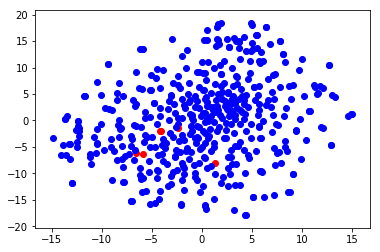

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=50)
fiftyDimVecs = pca.fit_transform([doc['vec'] for doc in docs])
tsne = TSNE(n_components=2)
twoDimVecs = tsne.fit_transform(fiftyDimVecs)

fig, ax = plt.subplots()
for doc, twoDimVec in zip(docs, twoDimVecs):
    ax.scatter(twoDimVec[0], twoDimVec[1], color=('r' if doc['name'].startswith('sieve') else 'b'))
plt.show()